## Agente Planejador-Executor

In [1]:
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-1.5-flash")

In [2]:
# Definindo o estado

import operator
from typing_extensions import TypedDict
from typing import Annotated, List, Tuple

class StatePlan(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [3]:
# Estrutura de resposta do LLM para a etapa de planejamento

from pydantic import BaseModel, Field

class Plan(BaseModel):
    steps: List[str] = Field(
        description="diferentes etapas a seguir, devem estar em ordem de classificação"
    )

In [4]:
# Nó de planejamento

from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Para o objetivo dado, crie um plano simples passo a passo. \
            Este plano deve envolver tarefas individuais que, se executadas corretamente, produzirão a resposta correta. Não adicione nenhuma etapa supérflua. \
            O resultado da etapa final deve ser a resposta final. Certifique-se de que cada etapa tenha todas as informações necessárias - não pule etapas"
        ),
        (
            "placeholder",
            "{messages}"
        ),
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)

In [5]:
# Testando o planner

planner.invoke(
    {
        "messages": [
            ("user", "Olá imobiliária stylus, tem apartamentos para alugar na varjota (fortaleza-ce)?")
        ]
    }
)


Plan(steps=['Verificar se a imobiliária Stylus possui apartamentos para alugar na Varjota (Fortaleza-CE).', 'Se sim, fornecer informações sobre os apartamentos disponíveis. Se não, informar que não há apartamentos disponíveis.'])

In [19]:
# Etapa de replanejamento

from typing import Union

class Response(BaseModel):
    """Responder ao usuário"""
    response: str

class Act(BaseModel):
    """Ação a ser executada"""

    action: Union[Response, Plan] = Field(
        description="Ação a ser executada. Se você quiser responder ao usuário, use Response. "
        "Se você precisar usar mais ferramentas para obter a resposta, use Plan."
    )

replanner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Para o objetivo dado, crie um plano simples passo a passo.
            Este plano deve envolver tarefas individuais que, se executadas corretamente, produzirão a resposta correta. Não adicione etapas supérfluas. 
            O resultado da etapa final deve ser a resposta final. Certifique-se de que cada etapa tenha todas as informações necessárias - não pule etapas.

            Seu objetivo era este:
            {input}

            Seu plano original era este:
            {plan}

            Você atualmente fez as seguintes etapas:
            {past_steps}

            Atualize seu plano adequadamente. Se não forem necessárias mais etapas e você puder retornar ao usuário, responda com isso. Caso contrário, preencha o plano. Adicione apenas etapas ao plano que ainda PRECISAM ser feitas. Não retorne etapas feitas anteriormente como parte do plano."""
        ),
        (
            "placeholder",
            "{messages}"
        )
    ]
)

replanner = replanner_prompt | llm.with_structured_output(Act)

Key '$defs' is not supported in schema, ignoring


In [20]:
# elaborando as funções dos nós

from langgraph.graph import END

def execute_step(state: StatePlan):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""
        Para o seguinte plano: {plan_str}\n\n
        Você é responsável pela tarefa {1}: {task}.
    """
    agent_response = llm.invoke(task_formatted)

    return {
        "past_steps": [(task, agent_response.content)]
    }

def plan_step(state: StatePlan):
    plan = planner.invoke(
        {
            "messages": [
                {"role": "user", "content": state["input"]}
            ]
        }
    )

    return {
        "plan": plan.steps
    }

def replan_steps(state: StatePlan):
    output = replanner.invoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.acition.steps}
    
def should_end(state: StatePlan):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [ ]:
# Construindo o gráfico

from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(StatePlan)

# Definindo os nós
graph_builder.add_node("planner", plan_step)
graph_builder.add_node("agent", execute_step)
graph_builder.add_node("replan", replan_steps)

# Definindo as pontes
graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "agent")
graph_builder.add_edge("agent", "replan")
graph_builder.add_conditional_edges("replan", should_end, ["agent", END])

# Compilando o grafo
app = graph_builder.compile()

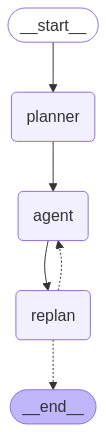

In [27]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [21]:
config = {"recursion_limit": 50}
inputs = {"input": "Quais as 3 maiores capitais do Brasil?"}
async for event in app.astream(inputs, config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Escreva uma lista de etapas que o usuário pode executar para criar uma mensagem.', 'Escreva uma mensagem para o usuário com as etapas.']}
{'past_steps': [('Escreva uma lista de etapas que o usuário pode executar para criar uma mensagem.', 'Aqui estão as etapas que um usuário pode seguir para criar uma mensagem:\n\n1. **Abra o aplicativo de mensagens ou plataforma de mídia social.** Isso pode ser feito no seu telefone, computador ou tablet.\n2. **Selecione o destinatário da sua mensagem.** Você pode fazer isso digitando o nome, número de telefone ou endereço de e-mail do destinatário ou selecionando-o da sua lista de contatos.\n3. **Digite sua mensagem.** Use o teclado para digitar o que você quer dizer.\n4. **Adicione quaisquer recursos adicionais, se desejar.** Isso pode incluir imagens, vídeos, emojis, GIFs ou arquivos.\n5. **Revise sua mensagem.** Certifique-se de que ela esteja livre de erros e que você esteja satisfeito com o conteúdo.\n6. **Envie sua mensagem.** Toque 

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
Retrying langchain_google_vertexai.ch

CancelledError: 

In [16]:
app.invoke({"input":"Olá, mundo!"})

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because at least one contents field is required. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.


KeyboardInterrupt: 